In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from typing import List, Tuple
import os
import csv
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import accuracy_score

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt # visual from MS-TCN and diffact https://github.com/Finspire13/DiffAct/blob/main/utils.py
def plot_barcode(gt=None, pred=None, show=True, save_file=None):

    # red = np.array([1, 0, 0, 1])
    red = [0.47, 0.11, 0.2, 1]  # RGB values for #c81c34
    red = np.append(np.array([200, 28, 52])/255, np.array([1]))
    # green = np.array([0, 1, 0, 1])
    green = [0.43, 0.76, 0.46, 1]  # RGB values for #6fc276
    green = np.append(np.array([38,140,47])/255, np.array([1]))
    colors = [red, green]
    color_map = LinearSegmentedColormap.from_list("Custom", colors, N=2)

    axprops = dict(xticks=[], yticks=[], frameon=False)
    barprops = dict(aspect='auto', cmap=color_map, 
                interpolation='nearest', vmin=0, vmax=1)

    # axprops = dict(xticks=[], yticks=[], frameon=False)
    # barprops = dict(aspect='auto', cmap=color_map, 
    #             interpolation='nearest', vmin=0, vmax=class_num-1)

    fig = plt.figure(figsize=(18, 4))

    # a horizontal barcode
    if gt is not None:
        ax1 = fig.add_axes([0, 0.45, 1, 0.2], **axprops)
        ax1.set_title('Ground Truth')
        ax1.imshow(gt.reshape((1, -1)), **barprops)

    if pred is not None:
        ax2 = fig.add_axes([0, 0.15, 1, 0.2], **axprops)
        ax2.set_title('Predicted')
        ax2.imshow(pred.reshape((1, -1)), **barprops)

    if save_file is not None:
        fig.savefig(save_file, dpi=400)
    if show:
        plt.show()
    plt.close()


In [3]:
def condense_dataframe(df: pd.DataFrame, priority: dict = None) -> pd.DataFrame:
    """
    deals with duplicate images which have multiple contact states
    
    Condenses a pandas DataFrame by ensuring each 'image' entry is unique and retains
    the most relevant 'contact_label_pred' based on a set priority.

    The function operates under the rule that if multiple entries exist for the same 'image',
    it prioritizes keeping the entry with 'contact_label_pred' as "Portable Object Contact" over
    "Stationary Object Contact", and "Stationary Object Contact" over "No Contact". This is
    done by sorting the DataFrame according to the 'image' and a custom priority assigned to
    'contact_label_pred', then removing duplicate 'image' entries while keeping the entry with the
    highest-priority 'contact_label_pred'.
    """
    if priority is None:
        priority = {
            "Portable Object": 1,
            "Portable Object Contact": 1,
            "Stationary Object Contact": 2,
            "No Contact": 3
        }

    # Sort the DataFrame based on 'image' and the custom priority of 'contact_label_pred'

    df['priority'] = df['contact_label_pred'].map(priority)

    df = df.sort_values(by=['frame_id', 'priority'])

    # Drop the 'priority' column as it's no longer needed after sorting
    df.drop('priority', axis=1, inplace=True)

    # Remove duplicates, keeping the first occurrence
    df = df.drop_duplicates(subset='frame_id', keep='first')

    return df.iloc[df['frame_id'].map(lambda x: int(x.split('_')[0])).argsort()].reset_index(drop=True)

def get_last_indices_of_consecutive_labels2(df, transformation_dict):
    last_indices = {}
    last_label = None

    for index, row in df.iterrows():
        current_label = row['contact_label_pred']
        # If the current label is different from the last one, update the dictionary
        if current_label != last_label:
            if last_label is not None:  # to skip the very first label
                # Transform the label using the transformation_dict
                transformed_label = transformation_dict.get(last_label, last_label)
                last_indices[last_index] = transformed_label
            last_label = current_label
        last_index = index  # keep track of the last index
    
    # Add the last label and index after the loop
    # Transform the label using the transformation_dict
    transformed_label = transformation_dict.get(current_label, current_label)
    last_indices[last_index] = transformed_label
    return last_indices

def csv_to_tuples(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row if it exists
        for row in reader:
            # Skip the first column and convert the rest to integers
            holding_transitions, not_holding_transitions = map(int, row[1:])
            data.append((holding_transitions, not_holding_transitions))
    return data

def comparison_dicts(gt_transitions: List[tuple], max_len) -> Tuple[dict]:
    """
    Args:
        gt_transitions: List of tuples of ground truth transition frames in form [(start1, end1), (start2, end2) ...]
    """

    def transition_to_dict(trns: List[Tuple[int, int]]) -> dict:
        output_dict = {}
        for bound in trns:
            output_dict[bound[0]] = "red"
            output_dict[bound[1]] = "green"
        return output_dict
    
    trans_dict_gt = transition_to_dict(gt_transitions)
    trans_dict_gt[max_len] = "red"  # need to make remaining frames without contact red
    return trans_dict_gt


def plot_colored_horizontal_lines(col_dict1, col_dict2, line_height=1, label_offset=0.5, x_ticks_interval=None):
    """
    Plot two colored horizontal lines with labels to the left of them.

    :param col_dict1: Dictionary for the first line with keys as the end index of the color and values as the colors
    :param col_dict2: Dictionary for the second line with keys as the end index of the color and values as the colors
    :param line_height: Height of the lines
    :param label_offset: Offset to control the distance between lines and labels
    :param x_ticks_interval: Interval for x-axis ticks (set to None for automatic ticks)

    Example:
        col_dict1 = {15: 'blue', 20: 'red', 200: 'pink'}
        col_dict2 = {10: 'green', 30: 'purple', 90: 'orange', 120: "green"}
        plot_colored_horizontal_lines(col_dict1, col_dict2, line_height=1, label_offset=0.5, x_ticks_interval=50)
    """
    line_width = 10

    # Calculate figure height based on line_height and x_ticks_interval
    figure_height = line_height * 1.25 if x_ticks_interval else line_height

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(line_width, figure_height))

    # Initial start position for the first line
    start1 = 0
    for end, color in sorted(col_dict1.items()):
        ax.plot([start1, end], [0, 0], color=color, lw=line_width, solid_capstyle='butt')
        start1 = end

    # Initial start position for the second line
    start2 = 0
    for end, color in sorted(col_dict2.items()):
        ax.plot([start2, end], [-line_height, -line_height], color=color, lw=line_width, solid_capstyle='butt')
        start2 = end

    # Set the limits for the x-axis and y-axis
    max_x = max(max(col_dict1.keys()), max(col_dict2.keys()))
    ax.set_xlim(0, max_x)
    ax.set_ylim(-2 * line_height, line_height)

    # Remove the y-axis
    ax.yaxis.set_visible(False)

    # Remove the spines of the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add labels to the left of the lines with appropriate offset
    ax.text(-label_offset, 0, "Pred:", va='center', ha='right', fontsize=12, color='black')
    ax.text(-label_offset, -line_height, "GT:", va='center', ha='right', fontsize=12, color='black')

    # Set x-axis ticks every x_ticks_interval units if specified
    if x_ticks_interval is not None:
        ax.set_xticks(range(0, int(max_x) + 1, x_ticks_interval))
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis ticks by 45 degrees

    # Show the plot
    plt.tight_layout()
    plt.show()

transformation_dict = {"Portable Object Contact": "green", "Portable Object": "green", "Stationary Object Contact": "red", "No Contact": "red", "Self Contact": "red"}

# prettier version

0.9223956966675413


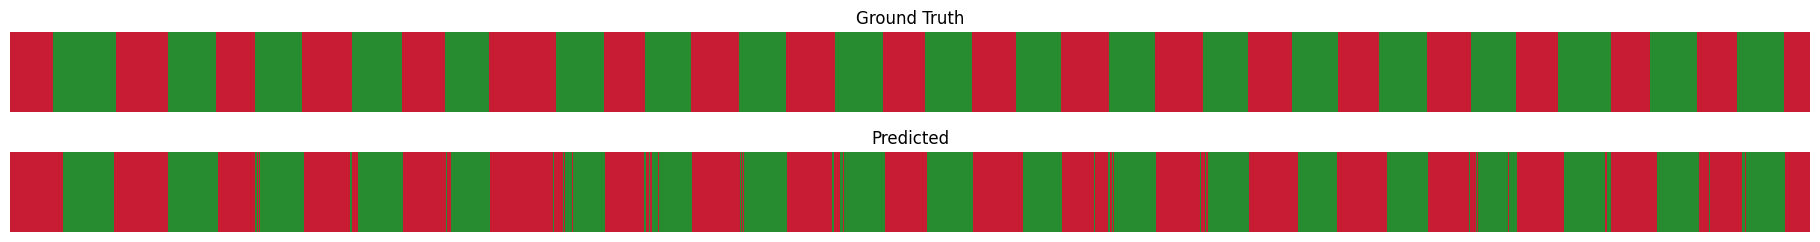

0.9262529213191378


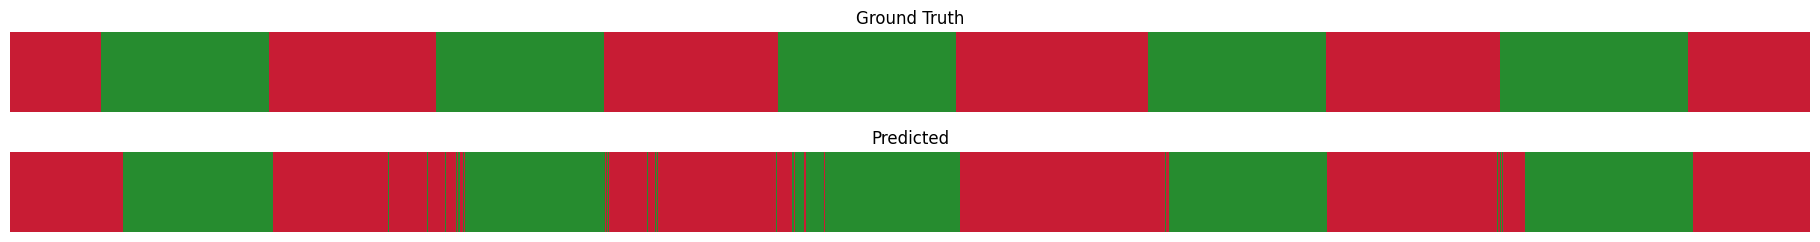

0.9130516080777861


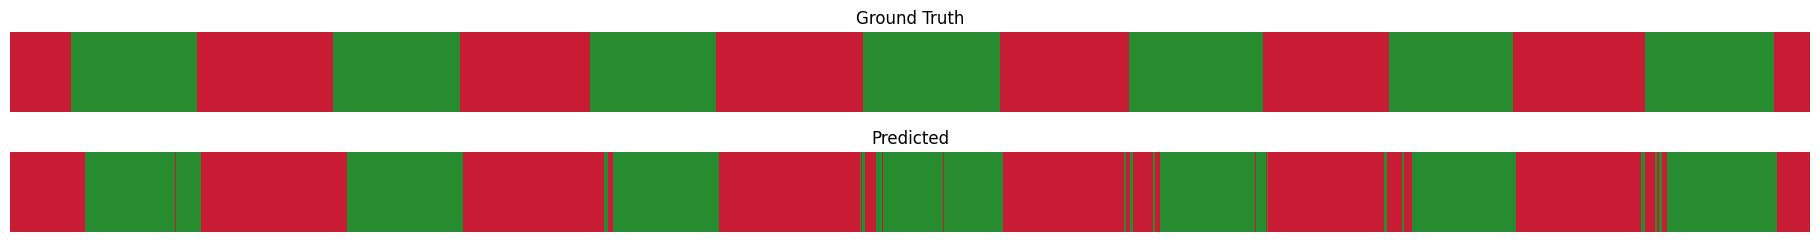

0.922426154287353


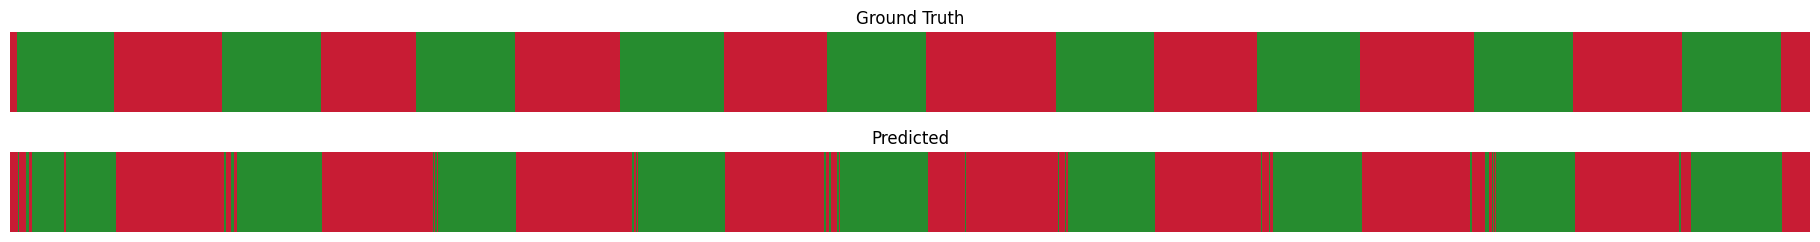

0.9237971391417426


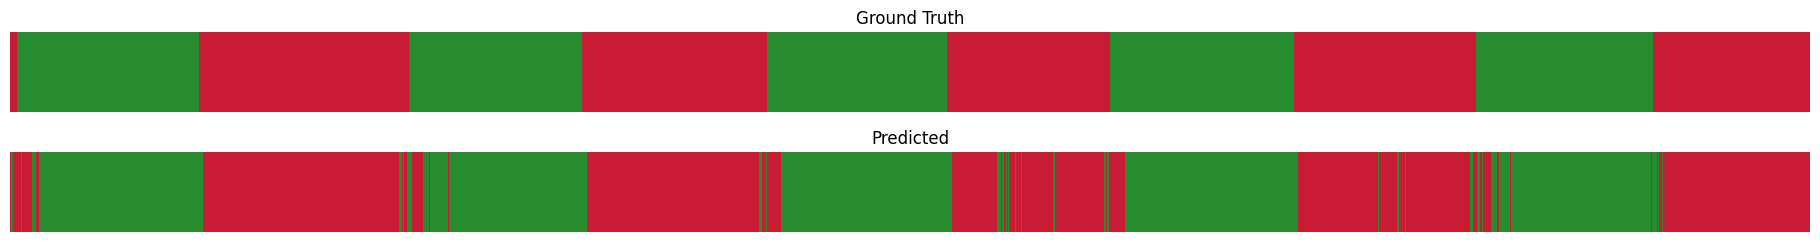

In [4]:
transformation_dict = {"Portable Object Contact": "green", "Portable Object": "green", "Stationary Object Contact": "red", "No Contact": "red", "Self Contact": "red"}

def display_bars_from_file(dir_: str, gt_dir: str):
    """uses old priority"""
    if dir_[-1] != "/":
        raise ValueError("NOAH! DIR NEEDS TO END IN '/'")

    raw_preds = pd.read_csv(dir_ + "pred_every_obj.csv")

    gt = pd.read_csv(dir_ + gt_dir)

    preds_cond = condense_dataframe(raw_preds, priority_old)
    pred_bin = preds_cond["contact_label_pred"].map({"Portable Object": 1, "No Contact": 0 , "Stationary Object Contact": 0, "Self Contact": 0}).to_numpy().astype(np.int8)
    gt_bin = gt["label"].map({"not_holding": 0, "holding": 1}).to_numpy().astype(np.int8)

    if len(gt_bin) < len(pred_bin):
        padding_length = len(pred_bin) - len(gt_bin)
        padding = np.zeros(padding_length)
        gt_bin = np.concatenate((gt_bin, padding))

    print(accuracy_score(gt_bin, pred_bin))
    plot_barcode(gt_bin, pred_bin)

    

sv_base = '/home/nripstein/Documents/thesis data/thesis labels/sv labels/'

directories = [sv_base + f'sv{i}_frames/' for i in (1, 2, 3, 4, 5)]

shrunks = [f"sv{i}_shrunk" for i in (1, 2, 3, 4, 5)]

gts = [f"sv{i}_frames_labels.csv" for i in (1, 2, 3, 4, 5)]


priority_old = {
            "Portable Object": 3,
            "Portable Object Contact": 3,
            "Stationary Object Contact": 2,
            "No Contact": 1
        }

for i in range(len(directories)):
    display_bars_from_file(directories[i], gts[i])


Accuracy: 0.92


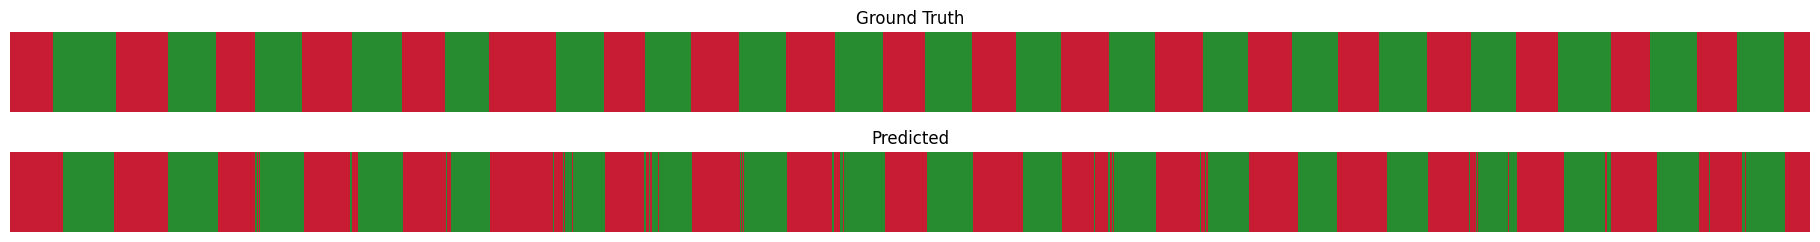

Accuracy: 0.93


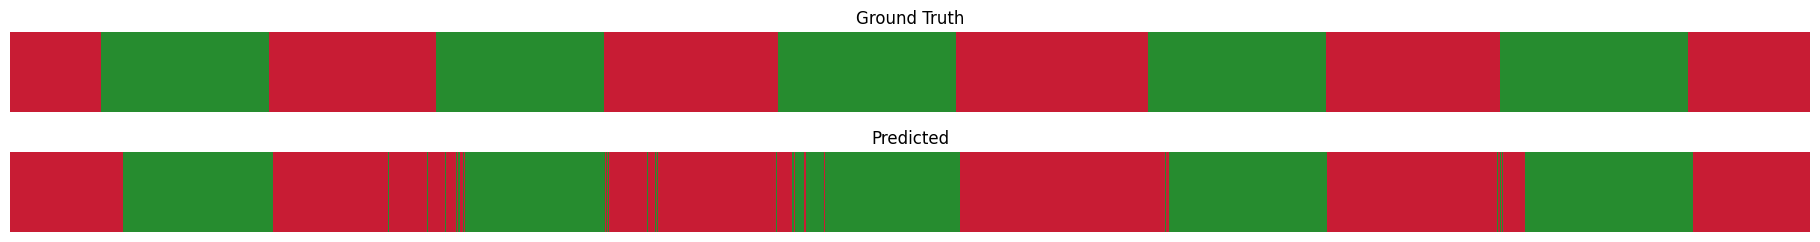

Accuracy: 0.91


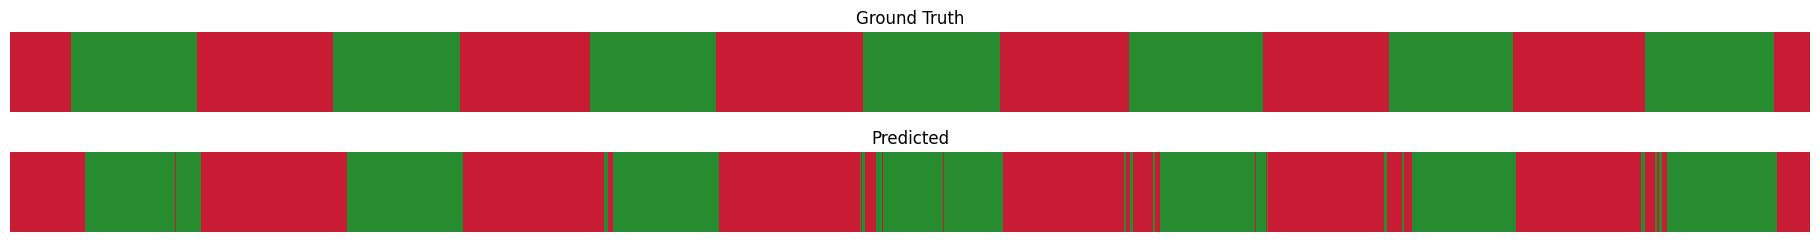

Accuracy: 0.92


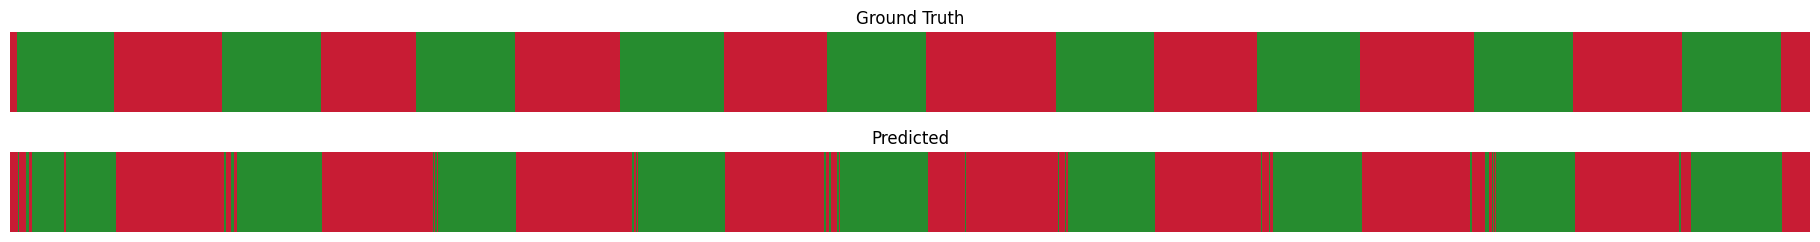

Accuracy: 0.92


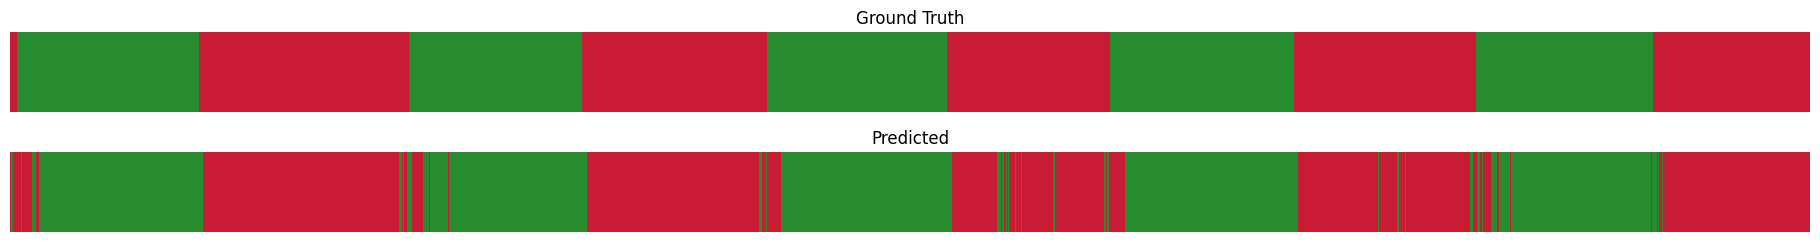

Overall Accuracy: 0.92


In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score


def extract_binary_arrays(dir_: str, gt_dir: str, priority_dict):
    """Extract binary arrays from ground truth and prediction CSV files."""
    if dir_[-1] != "/":
        raise ValueError("Directory path must end with '/'")
    
    # Read predictions and ground truth CSV files
    raw_preds = pd.read_csv(dir_ + "pred_every_obj.csv")
    gt = pd.read_csv(dir_ + gt_dir)

    # Transform labels according to specified mappings and priorities
    preds_cond = condense_dataframe(raw_preds, priority_dict)
    pred_bin = preds_cond["contact_label_pred"].map({"Portable Object": 1, "No Contact": 0, "Stationary Object Contact": 0, "Self Contact": 0}).to_numpy().astype(np.int8)
    gt_bin = gt["label"].map({"not_holding": 0, "holding": 1}).to_numpy().astype(np.int8)

    # Pad ground truth array if necessary
    if len(gt_bin) < len(pred_bin):
        padding_length = len(pred_bin) - len(gt_bin)
        padding = np.zeros(padding_length, dtype=np.int8)
        gt_bin = np.concatenate((gt_bin, padding))
    
    return gt_bin, pred_bin

def display_results(gt_bin, pred_bin):
    """Display accuracy and barcode plots for the given binary arrays."""
    # Calculate and print accuracy
    accuracy = accuracy_score(gt_bin, pred_bin)
    print(f"Accuracy: {accuracy:.2f}")

    # Display barcode plot
    plot_barcode(gt_bin, pred_bin)

# Base directory and file names setup
sv_base = '/home/nripstein/Documents/thesis data/thesis labels/sv labels/'
directories = [sv_base + f'sv{i}_frames/' for i in range(1, 6)]
gts = [f"sv{i}_frames_labels.csv" for i in range(1, 6)]
priority_old = {
    "Portable Object": 3,
    "Portable Object Contact": 3,
    "Stationary Object Contact": 2,
    "No Contact": 1
}


all_gt_bins = []
all_pred_bins = []

# Iterate through directories and process each
for dir_, gt_dir in zip(directories, gts):
    gt_bin, pred_bin = extract_binary_arrays(dir_, gt_dir, priority_old)
    display_results(gt_bin, pred_bin)
    all_gt_bins.append(gt_bin)
    all_pred_bins.append(pred_bin)

# Concatenate all arrays into single 1D arrays
all_gt_bin_sv = np.concatenate(all_gt_bins)
all_pred_bin_sv = np.concatenate(all_pred_bins)
print(f"Overall Accuracy: {accuracy_score(all_gt_bin_sv, all_pred_bin_sv):.2f}")


# SR

Accuracy: 0.87


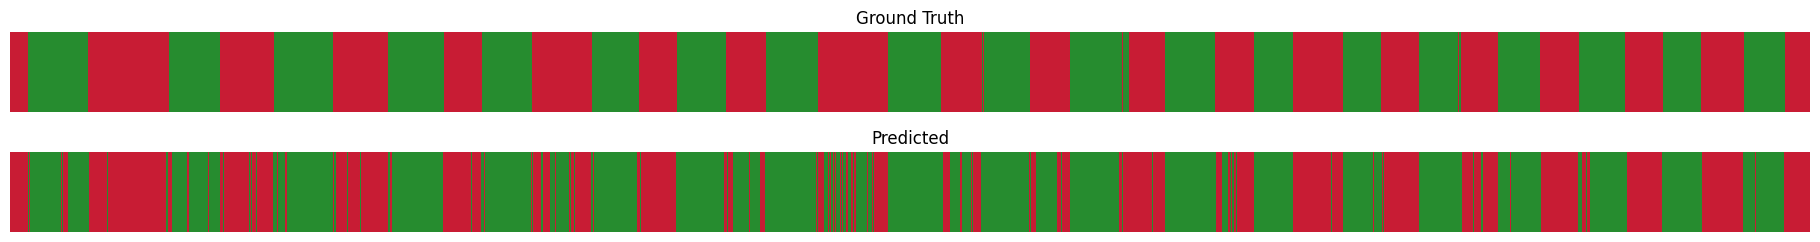

Accuracy: 0.91


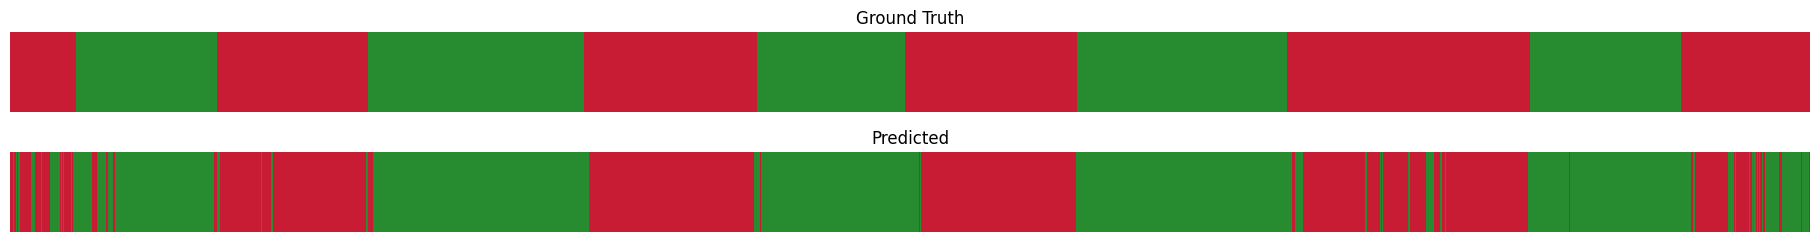

Accuracy: 0.90


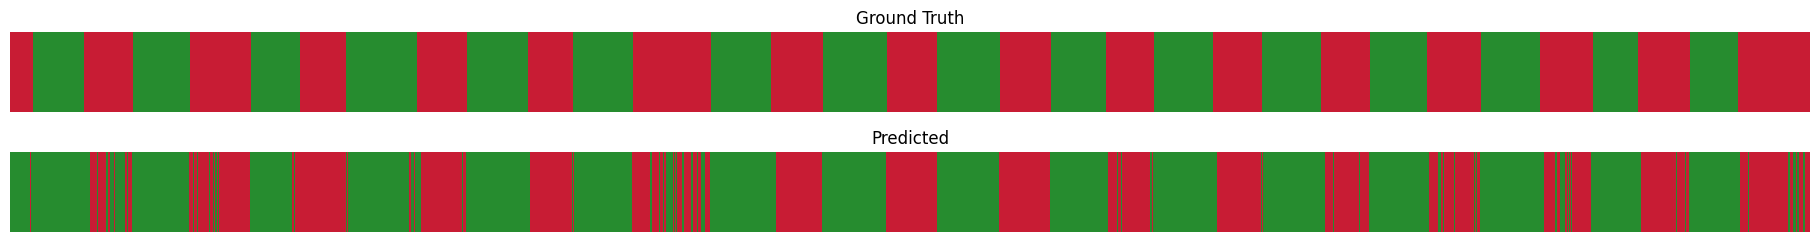

Accuracy: 0.92


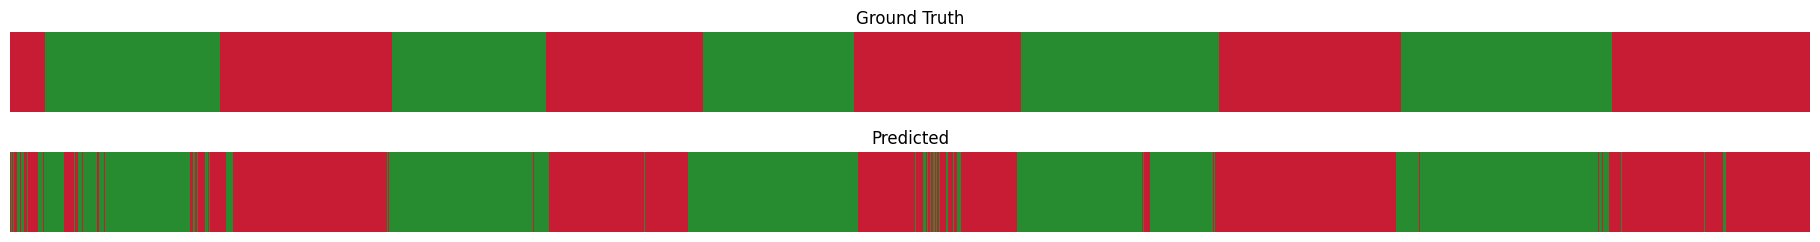

Overall Accuracy: 0.89


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score


def extract_binary_arrays(dir_: str, gt_dir: str, priority_dict):
    """Extract binary arrays from ground truth and prediction CSV files."""
    if dir_[-1] != "/":
        raise ValueError("Directory path must end with '/'")
    
    # Read predictions and ground truth CSV files
    raw_preds = pd.read_csv(dir_ + "pred_every_obj.csv")
    gt = pd.read_csv(dir_ + gt_dir)

    # Transform labels according to specified mappings and priorities
    preds_cond = condense_dataframe(raw_preds, priority_dict)
    pred_bin = preds_cond["contact_label_pred"].map({"Portable Object": 1, "No Contact": 0, "Stationary Object Contact": 0, "Self Contact": 0}).to_numpy().astype(np.int8)
    gt_bin = gt["label"].map({"not_holding": 0, "holding": 1}).to_numpy().astype(np.int8)

    # Pad ground truth array if necessary
    if len(gt_bin) < len(pred_bin):
        padding_length = len(pred_bin) - len(gt_bin)
        padding = np.zeros(padding_length, dtype=np.int8)
        gt_bin = np.concatenate((gt_bin, padding))
    
    return gt_bin, pred_bin

def display_results(gt_bin, pred_bin):
    """Display accuracy and barcode plots for the given binary arrays."""
    # Calculate and print accuracy
    accuracy = accuracy_score(gt_bin, pred_bin)
    print(f"Accuracy: {accuracy:.2f}")

    # Display barcode plot
    plot_barcode(gt_bin, pred_bin)

# Base directory and file names setup
sr_base = '/home/nripstein/Documents/thesis data/thesis labels/sr labels/'
directories = [sr_base + f'sr{i}/' for i in range(1, 5)]
gts = [f"sr{i}_labels.csv" for i in range(1, 5)]
priority_old = {
    "Portable Object": 3,
    "Portable Object Contact": 3,
    "Stationary Object Contact": 2,
    "No Contact": 1
}

all_gt_bins = []
all_pred_bins = []

# Iterate through directories and process each
for dir_, gt_dir in zip(directories, gts):
    gt_bin, pred_bin = extract_binary_arrays(dir_, gt_dir, priority_old)
    display_results(gt_bin, pred_bin)
    all_gt_bins.append(gt_bin)
    all_pred_bins.append(pred_bin)

# Concatenate all arrays into single 1D arrays
all_gt_bin_sr = np.concatenate(all_gt_bins)
all_pred_bin_sr = np.concatenate(all_pred_bins)
print(f"Overall Accuracy: {accuracy_score(all_gt_bin_sr, all_pred_bin_sr):.2f}")

# NR

Accuracy: 0.69


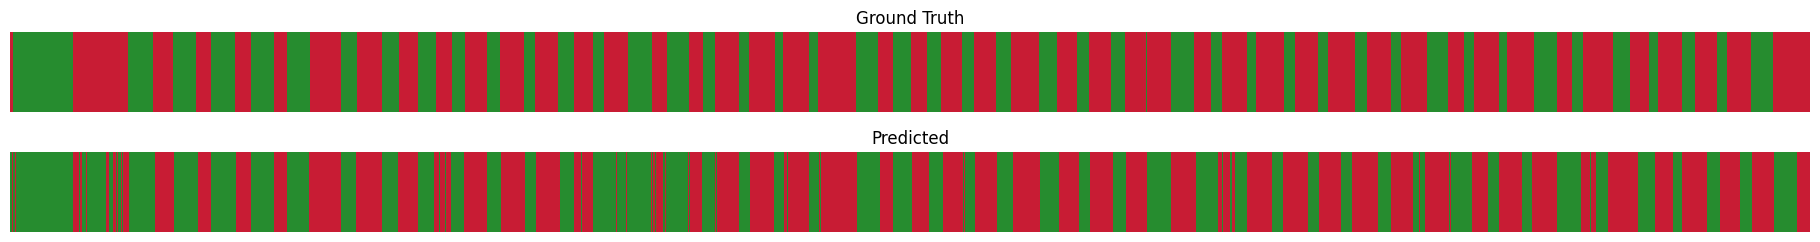

Overall Accuracy: 0.69


In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score


def extract_binary_arrays(dir_: str, gt_dir: str, priority_dict):
    """Extract binary arrays from ground truth and prediction CSV files."""
    if dir_[-1] != "/":
        raise ValueError("Directory path must end with '/'")
    
    # Read predictions and ground truth CSV files
    raw_preds = pd.read_csv(dir_ + "pred_every_obj.csv")
    gt = pd.read_csv(dir_ + gt_dir)

    # Transform labels according to specified mappings and priorities
    preds_cond = condense_dataframe(raw_preds, priority_dict)
    pred_bin = preds_cond["contact_label_pred"].map({"Portable Object": 1, "No Contact": 0, "Stationary Object Contact": 0, "Self Contact": 0}).to_numpy().astype(np.int8)
    gt_bin = gt["label"].map({"not_holding": 0, "holding": 1}).to_numpy().astype(np.int8)

    # Pad ground truth array if necessary
    if len(gt_bin) < len(pred_bin):
        padding_length = len(pred_bin) - len(gt_bin)
        padding = np.zeros(padding_length, dtype=np.int8)
        gt_bin = np.concatenate((gt_bin, padding))
    
    return gt_bin, pred_bin

def display_results(gt_bin, pred_bin):
    """Display accuracy and barcode plots for the given binary arrays."""
    # Calculate and print accuracy
    accuracy = accuracy_score(gt_bin, pred_bin)
    print(f"Accuracy: {accuracy:.2f}")

    # Display barcode plot
    plot_barcode(gt_bin, pred_bin)

# Base directory and file names setup
nr_base = '/home/nripstein/Documents/thesis data/thesis labels/nr labels/'
directories = [nr_base + "all_nr/"]
gts = ["all_nr_labels.csv"]
priority_old = {
    "Portable Object": 3,
    "Portable Object Contact": 3,
    "Stationary Object Contact": 2,
    "No Contact": 1
}

all_gt_bins = []
all_pred_bins = []

# Iterate through directories and process each
for dir_, gt_dir in zip(directories, gts):
    gt_bin, pred_bin = extract_binary_arrays(dir_, gt_dir, priority_old)
    display_results(gt_bin, pred_bin)
    all_gt_bins.append(gt_bin)
    all_pred_bins.append(pred_bin)

# Concatenate all arrays into single 1D arrays
all_gt_bin_nr = np.concatenate(all_gt_bins)
all_pred_bin_nr = np.concatenate(all_pred_bins)
print(f"Overall Accuracy: {accuracy_score(all_gt_bin_nr, all_pred_bin_nr):.2f}")

# Accuracy for everyone

In [10]:
all_gt_bin = np.concatenate([all_gt_bin_sv, all_gt_bin_sr, all_gt_bin_nr])
all_pred_bin = np.concatenate([all_pred_bin_sv, all_pred_bin_sr, all_pred_bin_nr])
print(f"Overall Accuracy: {accuracy_score(all_gt_bin, all_pred_bin):.2f}")

Overall Accuracy: 0.87
